In [1]:
#Modules
import re
import csv
import math
import itertools
import score_functions as sf
import numpy as np
import pandas as pd
import networkx as nx
import pathway_analysis as pa
import pickle

# Submodules
from cdlib import algorithms
from matplotlib import pyplot as plt

# Class and functions
from scipy.stats import zmap, norm
from copy import deepcopy
from collections import defaultdict

Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'graph_tool', 'wurlitzer', 'infomap'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'leidenalg', 'wurlitzer', 'infomap'}


In [2]:
with open('data/tar_genes_modules.pickle', 'rb') as f:
    tar_genes_modules = pickle.load(f)

with open('data/dis_genes_modules.pickle', 'rb') as f:
    dis_genes_modules = pickle.load(f)

In [3]:
with open('scores/average_shortest_path_score.pickle', 'rb') as f:
    scores_average_shortest_path = pickle.load(f)

with open('scores/exponential_decay_score.pickle', 'rb') as f:
    scores_exponential_decay = pickle.load(f)

In [4]:
with open('data/communities.pickle', 'rb') as f:
    cs = pickle.load(f)

In [6]:
aliases = pa.get_biogrid_aliases()

In [7]:
df_dis_genes = pd.read_csv('disease-gene.csv')
df_dis_genes['gene_name'] = df_dis_genes['gene_name'].apply(
    lambda x: aliases[x] if aliases.get(x) is not None else x)

In [8]:
# List of all the disease nodes
dis_genes = list(df_dis_genes['gene_name'])

In [9]:
G = nx.read_gpickle('data/protein_graph')

In [10]:
tar_genes = [n for n, target in G.nodes(data='target') if target]
tar_genes_order = {x: i for i, x in enumerate(tar_genes)}

In [11]:
node_index = {n: i for i, n in enumerate(G.nodes())}

# Read shortest path matrix
shortest_path_matrix = np.load('data/shortest_path_matrix.npy')
diameter = shortest_path_matrix.max()

### Statistical analysis of degree distribution

In [12]:
from collections import Counter
degree_list = list(G.degree())
degree_count = Counter([deg[1] for deg in degree_list])
degree_distribution = sorted((d for n, d in G.degree()), reverse=True)
deg, cnt = zip(*degree_count.items())

<BarContainer object of 528 artists>

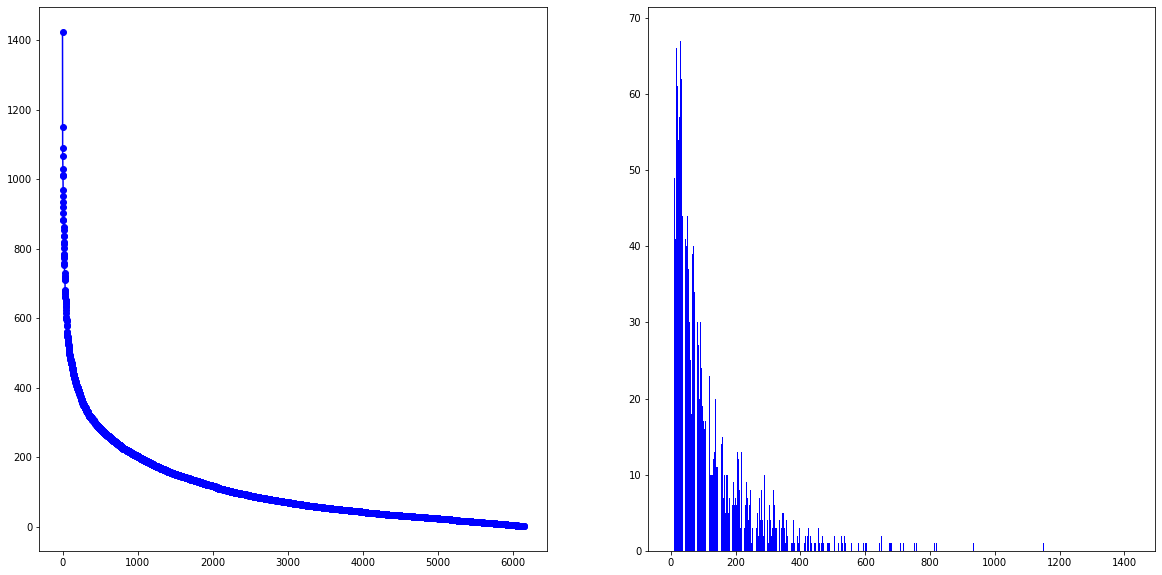

In [13]:
figure, axis = plt.subplots(1, 2, figsize= (20,10))
axis[0].plot(degree_distribution, "b-", marker="o")
axis[1].bar(deg, cnt, width=0.80, color='b')

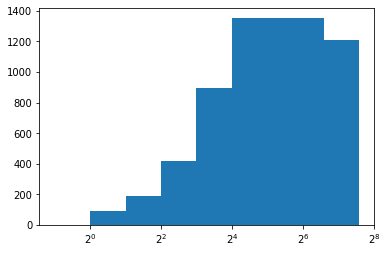

In [14]:
f, ax = plt.subplots(1)
log_bins = np.logspace(0, 8, 9, base = 2.0)
plt.xscale('log', base=2)
width = log_bins[1:] - log_bins[:-1]
hist = np.histogram(degree_distribution, bins = log_bins)
ax.bar(log_bins[:-1], hist[0], width)
plt.show(f)

### Create degree bins.
* group the genes with similar connectivity:
    * base 2 logarithmic bins are created in order to have bins that are large enough

In [15]:
bins = defaultdict(list)
for gene, deg in G.degree():
    bin = math.floor(math.log2(deg))
    bins[bin].append(gene)

### Create the bins for the modules's size conditioned on the target degree

In [16]:
module_size_bins = defaultdict(dict)

In [17]:
for gene in tar_genes:
    bin = math.floor(math.log2(G.degree(gene)))
    if tar_genes_modules.get(gene):
        for module in tar_genes_modules[gene]:
            bin_size = math.floor(math.log2(len(module)))
            if module_size_bins[bin].get(bin_size):
                module_size_bins[bin][bin_size] += 1
            else:
                module_size_bins[bin][bin_size] = 1

### Create random modules
* Random modules used to compute a reference score distribution useful to test the relevance of our scores
* A random target is selected from the bin of the original one to preserve its connectivity. A random walk of length 2 is then performed and each time a node is selected its counter is incremented
* The new nodes that will be part of the random module are then selected randomly from a non uniform distribution that gives more chance to be selected to the nodes mostly selected
* New nodes are added until we reach the size of the original module

In [18]:
import random
from numpy.random import choice

np.random.seed(1)

def random_module4(target):
    # Get the degree bin of the target
    bin = math.floor(math.log2(G.degree(target)))
    # Choose a random target in the same degree bin
    random_target = random.choice(bins[bin])
    #sample a size bin for the new module
    size_dist = [s for s in module_size_bins[bin].values()]
    size_dist = [x / sum(size_dist) for x in size_dist]
    new_module_size_bin = choice(list(module_size_bins[bin].keys()), p = size_dist)

    #sample the actual size randomly in the bin
    new_module_size = random.randint(2**new_module_size_bin, 2**(new_module_size_bin + 1)  - 1)

    #print(new_module_size)
    rand_module = {random_target}
    counter = defaultdict(int)
    for i in range(1000):
        path_len = 0
        node = random_target
        while path_len < 2:
            node = random.choice(list(G.neighbors(node)))
            if node != random_target:
                counter[node] += 1
                path_len += 1

    total= sum(counter.values())
    p_dist = [counter[c] / total for c in counter.keys()]
    nodes = [n for n in counter.keys()]
    if len(nodes) < new_module_size:
        return  (random_target, 0)
    degree_distribution = list(zip(nodes, p_dist))
    while len(rand_module) < new_module_size:
        new_node = choice(nodes, p = p_dist)
        all_paths = list(nx.all_simple_paths(G, source = random_target, target= new_node, cutoff=2))
        path = random.choice(all_paths)
        rand_module.update(node for node in path)
    print(len(rand_module))
    return (random_target, rand_module)

In [19]:
modules = defaultdict(list)
i = 0
n_random_nodes = int(0.2*G.number_of_nodes())
while i < n_random_nodes:
    #select a random module from which the new random one will be created
    starting_tagret = random.choice(list(tar_genes_modules.keys()))
    res = random_module4(starting_tagret)
    if res[1] != 0:
        i += 1
        modules[res[0]].append([i, res[1]])

7
26
11
11
3
11
3
6
3
8
5
10
17
30
3
5
39
3
11
5
9
10
9
5
9
14
5
5
14
5
8
12
44
16
8
15
15
17
14
4
5
6
26
7
2
8
7
5
5
8
15
15
5
29
38
15
7
19
6
32
11
7
10
10
15
5
15
7
4
3
8
7
14
3
3
10
28
5
9
8
6
11
5
7
13
5
5
5
9
9
4
6
6
5
8
15
61
7
4
5
9
7
13
3
26
12
9
7
7
5
3
13
2
6
3
13
7
13
5
4
16
11
11
6
13
24
7
8
6
11
12
7
3
25
6
155
6
8
6
5
29
10
10
15
5
53
29
10
15
14
4
19
9
3
6
7
4
14
15
4
7
7
7
5
8
7
13
9
5
11
8
3
7
15
12
3
3
15
5
11
9
11
11
8
7
12
7
23
9
9
13
6
7
16
13
28
6
2
3
7
11
5
21
5
15
35
7
5
9
3
14
11
18
2
7
6
5
9
32
3
3
5
7
7
27
4
2
29
25
6
8
5
9
10
31
3
19
3
7
9
4
23
13
3
7
5
8
6
3
5
5
23
22
11
13
5
15
10
5
8
21
3
5
5
5
23
7
3
6
3
7
15
7
11
7
5
8
7
2
13
13
3
9
7
6
16
8
12
6
12
3
5
9
7
12
5
30
5
6
3
7
21
7
3
7
6
11
5
6
5
7
5
10
14
7
5
4
5
3
5
7
9
15
5
5
9
13
5
4
13
6
7
5
13
12
14
3
3
7
21
11
15
5
10
11
12
11
7
18
10
8
3
6
5
5
5
14
14
7
27
15
3
8
3
3
5
3
13
23
14
5
15
14
5
7
13
7
15
3
4
5
7
6
13
7
4
3
15
3
6
4
8
4
14
27
10
16
3
11
4
5
11
6
15
11
7
27
8
9
6
16
6
7
12
10
28
8
13
7
7


{'whiskers': [<matplotlib.lines.Line2D at 0x1bdbf2f28f0>,
 'caps': [<matplotlib.lines.Line2D at 0x1bdbf2f2f50>,
 'boxes': [<matplotlib.lines.Line2D at 0x1bdbf2f2680>],
 'medians': [<matplotlib.lines.Line2D at 0x1bdbf2f3430>],
 'fliers': [<matplotlib.lines.Line2D at 0x1bdbf2f3700>],
 'means': []}

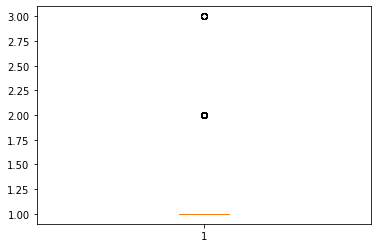

In [20]:
module_size = [len(x[1]) for x in modules.items()]
plt.boxplot(module_size)

In [21]:
dis_genes_order = {}
count = 0
for disease, data in df_dis_genes.groupby('disease'):
    for gene_name in data['gene_name']:
        dis_genes_order[gene_name] = count
        count += 1

In [22]:
rand_tar_genes_order = {x:i for i,x in enumerate(modules)}

In [23]:
row_partitioning = []
for dis, data in df_dis_genes.groupby('disease'):
    a = [dis_genes_order[gene] for gene in data['gene_name'] if gene in dis_genes_order]
    row_partitioning.append(a[-1])

### Exponential decay score

In [24]:
scores_exponential_decay_random = np.zeros([len(dis_genes), len(modules.keys())])
rand_mod = []
for el in modules.values():
    for module in el:
        rand_mod.append(list(module[1]))
precomputed_scores_random = {}
for dis, tar in itertools.product(dis_genes, list(modules.keys())):
    score = sf.best_score(cs, dis, tar, min=False, score_function=sf.exponential_decay_score,
                       shortest_path_matrix=shortest_path_matrix,
                       node_index=node_index, precomputed_scores=precomputed_scores_random, random_modules=modules)
    scores_exponential_decay_random[dis_genes_order[dis], rand_tar_genes_order[tar]] = score

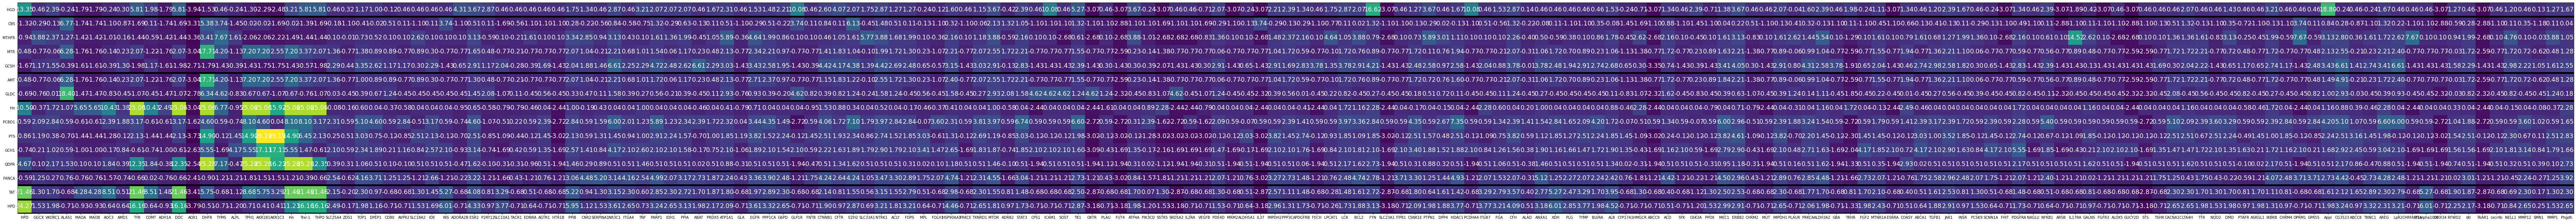

In [25]:
#compute zscore
z_scores = zmap(scores_exponential_decay, scores_exponential_decay_random, axis=1)
sf.show_score_matrix(z_scores, tar_genes_order, dis_genes_order, row_partitioning)

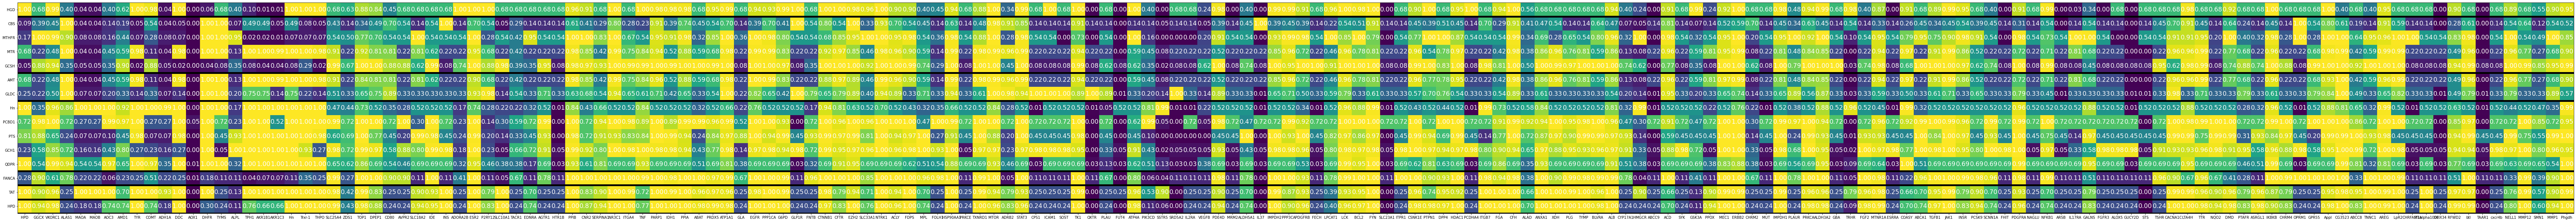

In [26]:
cdf_scores = norm.cdf(z_scores)
sf.show_score_matrix(cdf_scores, tar_genes_order, dis_genes_order, row_partitioning)

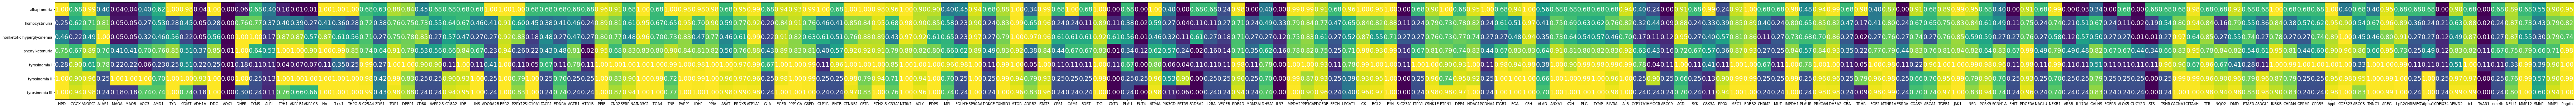

In [27]:
disease_scores = {}
for dis, data in df_dis_genes.groupby('disease'):
    # gene list (order) of the disease genes
    a = [dis_genes_order[gene] for gene in data['gene_name'] if gene in dis_genes_order]
    ds = cdf_scores[a, :]
    disease_scores[dis] = np.mean(ds, axis=0)

disease_order = {}
scores_list = []
count = 0
for key in disease_scores.keys():
    disease_order[key] = count
    count += 1
    scores_list.append(disease_scores[key])
mean_scores = np.stack(scores_list)
sf.show_score_matrix(mean_scores, tar_genes_order, disease_order)

In [28]:
column_names = ["" for i in range(len(disease_order))]
row_names = ["" for i in range(len(tar_genes_order))]
for key in disease_order:
    column_names[disease_order[key]] = key
for key in tar_genes_order:
    row_names[tar_genes_order[key]] = key
df_scores = pd.DataFrame(mean_scores.T, index=row_names, columns=column_names)
df_scores

alkaptonuria  homocystinuria  nonketotic hyperglycinemia  \
HPD         1.000000        0.249209                    0.464721   
GGCX        0.679027        0.621664                    0.222232   
VKORC1      0.991537        0.713914                    0.489864   
ALAS1       0.404165        0.811248                    1.000000   
MAOA        0.037021        0.052969                    0.054875   
...              ...             ...                         ...   
NELL1       0.885846        0.874991                    0.874816   
MMP12       0.679027        0.732716                    0.545535   
SMN1        0.550944        0.432035                    0.297133   
MMP1        0.897311        0.793304                    0.787528   
Phgdh       0.952250        0.815740                    0.735821   

        phenylketonuria  tyrosinemia I  tyrosinemia II  tyrosinemia III  
HPD            0.751388       0.277111        1.000000         1.000000  
GGCX           0.668173       0.895036        0.903959         0.937103  
VKORC1         0.886558       0.606286        0.955563         0.976081  
ALAS1          0.696171       0.776883        0.248197         0.239275  
MAOA           0.408450       0.223869        0.999991         0.175325  
...                 ...            ...             ...              ...  
NELL1          0.748552       0.326533        0.756094         0.800053  
MMP12          0.791286       0.987385        0.989184         0.995983  
SMN1           0.662435       0.393862        0.567643         0.599157  
MMP1           0.714848       0.895036        0.903959         0.937103  
Phgdh          0.977059       0.999956        0.989184         0.995983  

[182 rows x 7 columns]

In [29]:
df_scores.to_csv('disease-target-scores.csv')

### Average shortest path score

In [30]:
scores_shortest_path_random = np.zeros([len(dis_genes), len(modules.keys())])
rand_mod = []
for el in modules.values():
    for module in el:
        rand_mod.append(list(module[1]))
precomputed_scores_random = {}
for dis, tar in itertools.product(dis_genes, list(modules.keys())):
    score = sf.best_score(cs, dis, tar, min=False, score_function=sf.D,
                       shortest_path_matrix=shortest_path_matrix,
                       node_index=node_index, precomputed_scores=precomputed_scores_random, random_modules=modules, diameter=diameter)
    scores_shortest_path_random[dis_genes_order[dis], rand_tar_genes_order[tar]] = score

In [31]:
z_scores_shortest_path = zmap(scores_average_shortest_path, scores_shortest_path_random, axis=1)
#sf.show_score_matrix(z_scores_shortest_path, tar_genes_order, dis_genes_order, row_partitioning)

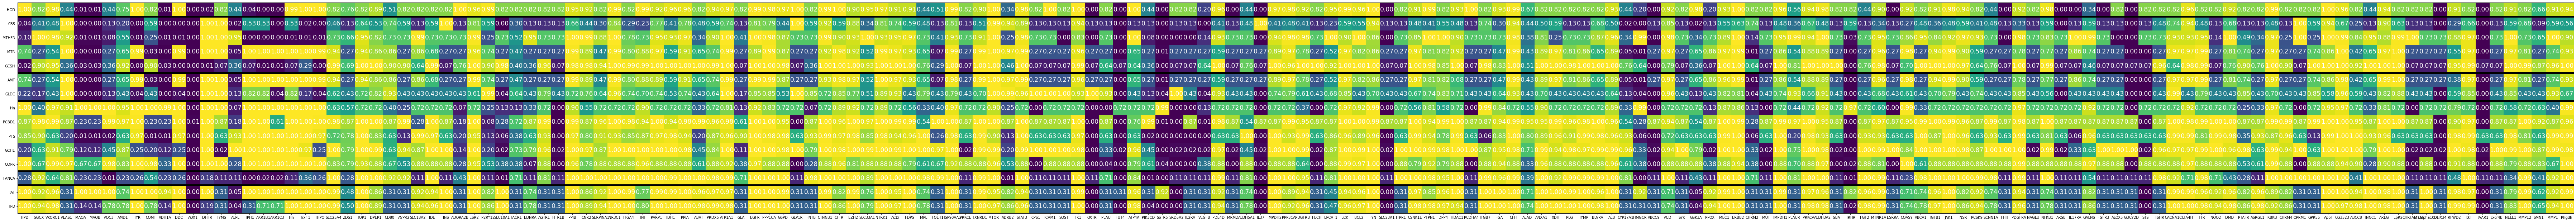

In [32]:
cdf_scores_shortest_path = norm.cdf(z_scores_shortest_path)
sf.show_score_matrix(cdf_scores_shortest_path, tar_genes_order, dis_genes_order, row_partitioning)

In [33]:
disease_scores2 = {}
for dis, data in df_dis_genes.groupby('disease'):
    # gene list (order) of the disease genes
    a = [dis_genes_order[gene] for gene in data['gene_name'] if gene in dis_genes_order]
    ds = cdf_scores_shortest_path[a, :]
    disease_scores2[dis] = np.mean(ds, axis=0)

disease_order = {}
scores_list = []
count = 0
for key in disease_scores2.keys():
    disease_order[key] = count
    count += 1
    scores_list.append(disease_scores2[key])
mean_scores = np.stack(scores_list)

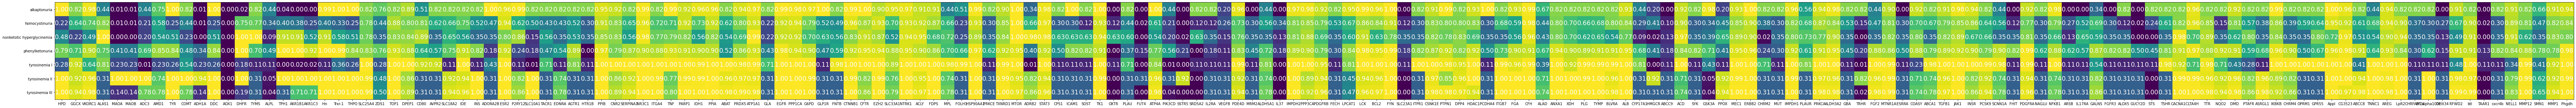

In [34]:
sf.show_score_matrix(mean_scores, tar_genes_order, disease_order)

In [35]:
column_names = ["" for i in range(len(disease_order))]
row_names = ["" for i in range(len(tar_genes_order))]
for key in disease_order:
    column_names[disease_order[key]] = key
for key in tar_genes_order:
    row_names[tar_genes_order[key]] = key
df_scores = pd.DataFrame(mean_scores.T, index=row_names, columns=column_names)
df_scores

alkaptonuria  homocystinuria  nonketotic hyperglycinemia  \
HPD         1.000000        0.223012                    0.480454   
GGCX        0.818410        0.643002                    0.216160   
VKORC1      0.975056        0.738560                    0.486942   
ALAS1       0.443428        0.819740                    1.000000   
MAOA        0.007411        0.010791                    0.001480   
...              ...             ...                         ...   
NELL1       0.905541        0.889148                    0.911447   
MMP12       0.818410        0.805420                    0.624660   
SMN1        0.658568        0.467579                    0.350262   
MMP1        0.911089        0.820049                    0.832319   
Phgdh       0.941393        0.843955                    0.798745   

        phenylketonuria  tyrosinemia I  tyrosinemia II  tyrosinemia III  
HPD            0.785245       0.284161        1.000000         1.000000  
GGCX           0.714551       0.923399        0.920462         0.944747  
VKORC1         0.897098       0.641424        0.963290         0.978062  
ALAS1          0.749999       0.814684        0.307855         0.308249  
MAOA           0.406666       0.225955        0.999990         0.141713  
...                 ...            ...             ...              ...  
NELL1          0.843169       0.338425        0.794021         0.829139  
MMP12          0.881468       0.993691        0.990942         0.995907  
SMN1           0.775098       0.412344        0.624259         0.654605  
MMP1           0.782555       0.923399        0.920462         0.944747  
Phgdh          0.984312       0.999922        0.990942         0.995907  

[182 rows x 7 columns]

In [36]:
df_scores.to_csv('disease-target-scores-shortest-path.csv')

### Test with easy method (deprecated)

In [24]:
#Modules
import math
import itertools
import score_functions as sf
import numpy as np
import pandas as pd
import networkx as nx
import pathway_analysis as pa
import pickle

# Submodules
from cdlib import algorithms
from matplotlib import pyplot as plt

# Class and functions
from scipy.stats import zmap, norm
from copy import deepcopy
from collections import defaultdict


In [5]:
# Read graph
G = nx.read_gpickle('data/protein_graph')
# Read score matrix
with open('scores/average_shortest_path_score.pickle', 'rb') as f:
    scores_average_shortest_path = pickle.load(f)
with open('scores/exponential_decay_score.pickle', 'rb') as f:
    scores_exponential_decay = pickle.load(f)

# Read community object
with open('data/communities.pickle', 'rb') as f:
    cs = pickle.load(f)

# Read node_index
with open('data/node_index', 'rb') as f:
    node_index = pickle.load(f)

# Read shortest path matrix
shortest_path_matrix = np.load('data/shortest_path_matrix.npy')
diameter = shortest_path_matrix.max()


In [26]:
aliases = pa.get_biogrid_aliases()
df_dis_genes = pd.read_csv('disease-gene.csv')
df_dis_genes['gene_name'] = df_dis_genes['gene_name'].apply(
    lambda x: aliases[x] if aliases.get(x) is not None else x)
dis_genes = list(df_dis_genes['gene_name'])
dis_genes_order = {}
count = 0
for disease, data in df_dis_genes.groupby('disease'):
    for gene_name in data['gene_name']:
        dis_genes_order[gene_name] = count
        count += 1


In [27]:
tar_genes = [n for n, target in G.nodes(data='target') if target]
tar_genes_order = {x: i for i, x in enumerate(tar_genes)}

In [28]:
row_partitioning = []
for dis, data in df_dis_genes.groupby('disease'):
    a = [dis_genes_order[gene] for gene in data['gene_name'] if gene in dis_genes_order]
    row_partitioning.append(a[-1])


In [29]:
n_random_nodes = int(0.4*G.number_of_nodes())
random_nodes_index = np.random.choice(G.number_of_nodes(), n_random_nodes, replace=False)
random_genes = np.array(G.nodes())[[random_nodes_index]]
random_genes_order = {x: i for i, x in enumerate(random_genes)}

In [31]:
ncm_lengths = [len(cs.to_node_community_map()[gene]) for gene in G.nodes()]
lower_perc = np.percentile(ncm_lengths, 75)
upper_perc = np.percentile(ncm_lengths, 95)

In [32]:
scores_random_ed = np.zeros([len(dis_genes), len(random_genes)])
precomputed_scores = {}
for dis, tar in itertools.product(dis_genes, random_genes):
    n_mod_dis = len(cs.to_node_community_map()[dis])
    if n_mod_dis > upper_perc:
        sample_dis = random.randint(lower_perc, upper_perc)
    else:
        sample_dis = None
    
    n_mod_tar = len(cs.to_node_community_map()[tar])
    if n_mod_tar > upper_perc:
        sample_tar = random.randint(lower_perc, upper_perc)
    else:
        sample_tar = None

    score = sf.best_score(cs, dis, tar, min=False, score_function=sf.exponential_decay_score,
                       shortest_path_matrix=shortest_path_matrix, sample_dis=sample_dis, sample_tar=sample_tar,
                       node_index=node_index, precomputed_scores=precomputed_scores)
    scores_random_ed[dis_genes_order[dis], random_genes_order[tar]] = score 

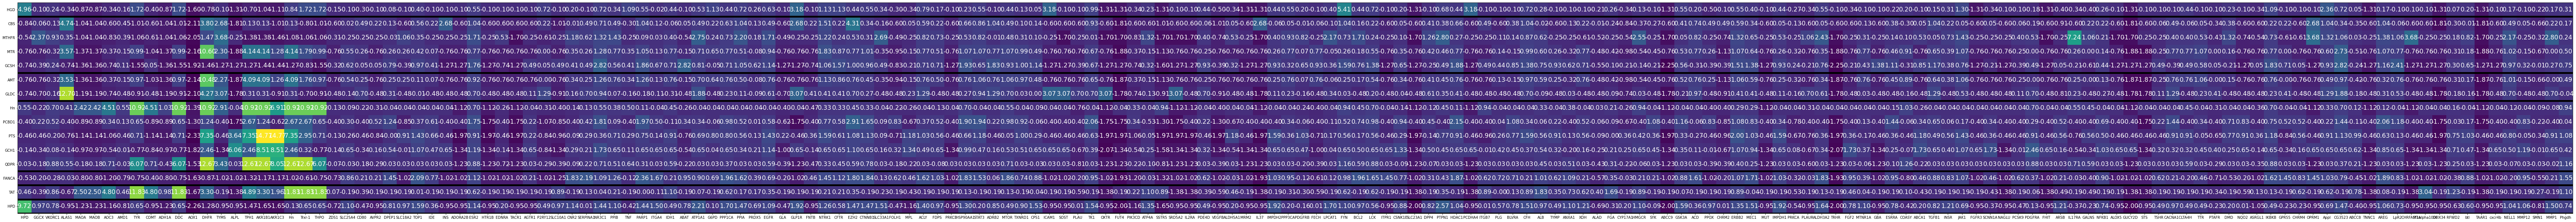

In [34]:
z_scores_exponential_decay = zmap(scores_exponential_decay, scores_random_ed, axis=1)
sf.show_score_matrix(z_scores_exponential_decay, tar_genes_order, dis_genes_order, row_partitioning)

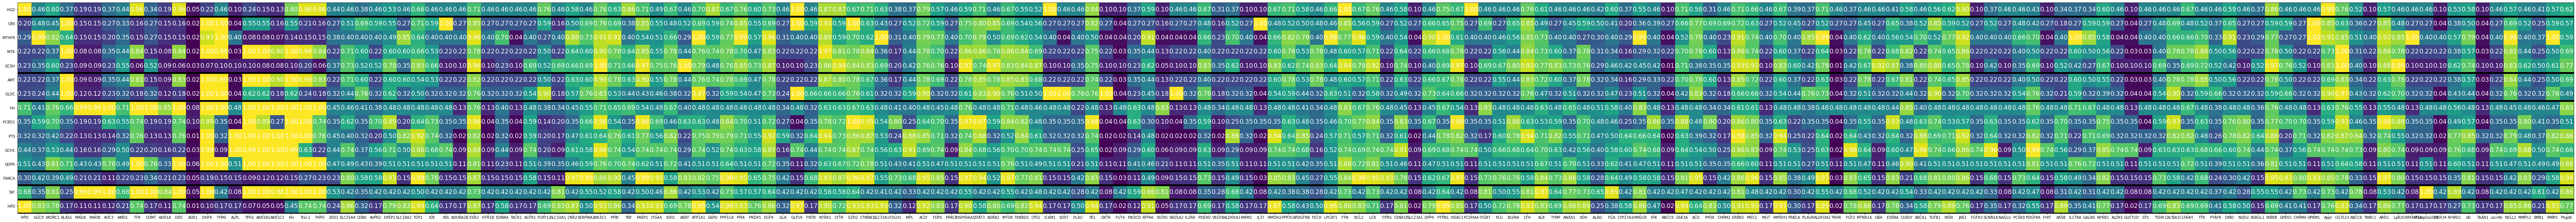

In [35]:
cdf_scores_exponential_decay = norm.cdf(z_scores_exponential_decay)
sf.show_score_matrix(cdf_scores_exponential_decay, tar_genes_order, dis_genes_order, row_partitioning)

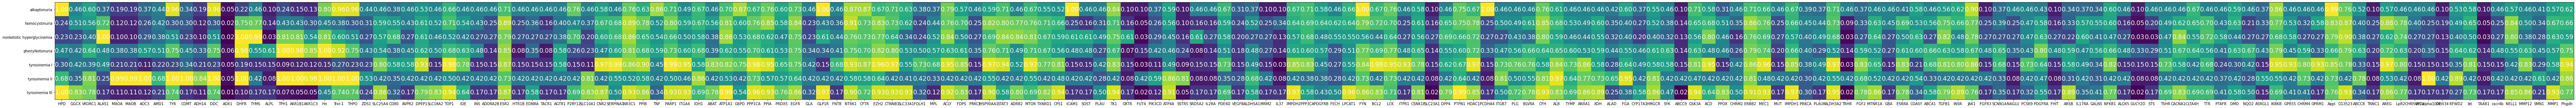

In [36]:
disease_scores = {}
for dis, data in df_dis_genes.groupby('disease'):
    # gene list (order) of the disease genes
    a = [dis_genes_order[gene] for gene in data['gene_name'] if gene in dis_genes_order]
    ds = cdf_scores_exponential_decay[a, :]
    disease_scores[dis] = np.mean(ds, axis=0)

disease_order = {}
scores_list = []
count = 0
for key in disease_scores.keys():
    disease_order[key] = count
    count += 1
    scores_list.append(disease_scores[key])
mean_scores = np.stack(scores_list)
sf.show_score_matrix(mean_scores, tar_genes_order, disease_order)

In [37]:
column_names = ["" for i in range(len(disease_order))]
row_names = ["" for i in range(len(tar_genes_order))]
for key in disease_order:
    column_names[disease_order[key]] = key
for key in tar_genes_order:
    row_names[tar_genes_order[key]] = key
df_scores = pd.DataFrame(mean_scores.T, index=row_names, columns=column_names)
df_scores.to_csv('disease-target-scores-exponential-decay.csv')